# Import packages

In [1]:
import os
import cmaps
import cmocean
import numpy as np
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from netCDF4 import Dataset
from datetime import date
from mpl_toolkits.basemap import Basemap
from matplotlib.pyplot import Polygon
from matplotlib import rcParams
from xarrayMannKendall import Mann_Kendall_test
directory   = '/srv/scratch/z3533156'
from dask.distributed import Client
from astropy import convolution
rcParams['font.family'] = 'sans-serif'
import PUG_functions as PF

# Read large scale wind stress data

In [2]:
dataset1     = xr.open_dataset(directory+'/BRAN_WBC/SO/ERA5/ERA5_monthly_Tx_LS.nc')
dataset2     = xr.open_dataset(directory+'/BRAN_WBC/SO/ERA5/ERA5_monthly_Ty_LS.nc')
dataset3     = xr.open_dataset(directory+'/BRAN_WBC/SO/ERA5/ERA5_monthly_curlZ_LS.nc')
dataset4     = xr.open_dataset(directory+'/BRAN_WBC/SO/ERA5/ERA5_monthly_u10_LS.nc')
lon          = np.tile(dataset1.lon, (len(dataset1.lat),1)).transpose()+180
lat          = np.tile(dataset1.lat, (len(dataset1.lon),1))
Tx_mean0     = dataset1.Tx.transpose().mean(axis=2)
Ty_mean0     = dataset2.Ty.transpose().mean(axis=2)
curlZ_mean0  = dataset3.curlZ.transpose().mean(axis=2)*1e7
u10_0        = np.nanmean(dataset4.u10.values,axis=0).transpose()
Tx_mean      = np.concatenate((Tx_mean0[720:,:],Tx_mean0[:720,:]),axis=0)
Ty_mean      = np.concatenate((Ty_mean0[720:,:],Ty_mean0[:720,:]),axis=0)
curlZ_mean   = np.concatenate((curlZ_mean0[720:,:],curlZ_mean0[:720,:]),axis=0)
u10_mean     = np.fliplr(np.concatenate((u10_0[720:,360:601],u10_0[:720,360:601]),axis=0))
u10_mean1    = np.fliplr(np.concatenate((u10_0[720:,360:601],u10_0[:720,360:601]),axis=0))
dataset0  = sio.loadmat(directory+'/BRAN_WBC/SO/Figure2_mean.mat')
sst_mean  = dataset0['oisst_mean'][:,:-1]
u10_mean[np.where(np.isnan(sst_mean))]=np.nan
Tx_mean[np.where(np.isnan(sst_mean))]=np.nan
Ty_mean[np.where(np.isnan(sst_mean))]=np.nan
curlZ_mean[np.where(np.isnan(sst_mean))]=np.nan
u10_mean1[np.where(np.isnan(sst_mean))]=np.nan

# Read SAM index and zonal mean wind

In [3]:
dataset5   = sio.loadmat(directory+'/BRAN_WBC/SO/Figure5_lat_wind.mat')
lat0       = dataset5['lat0'][:,0]
SAM_index  = dataset5['SAM_index'][:,0]
mean_curlZ = dataset5['mean_curlZ'][0,:]
mean_u10   = dataset5['mean_u10'][0,:]
SAM_index_trend   = dataset5['SAM_index_trend'][:,0]
mean_u10_trend    = dataset5['mean_u10_trend'][0,:]*120
latitudes_0_curlZ = dataset5['latitudes_0_curlZ'][0,:]
latitudes_0_u10   = dataset5['latitudes_0_u10'][0,:]
latitudes_m_u10   = dataset5['latitudes_m_u10'][0,:]
u10_zonal_mean    = dataset5['u10_zonal'][:,6:-5]
latitudes_0_curlZ_trend = dataset5['latitudes_0_curlZ_trend'][0,:]
latitudes_0_u10_trend   = dataset5['latitudes_0_u10_trend'][0,:]
latitudes_m_u10_trend   = dataset5['latitudes_m_u10_trend'][0,:]
time_start = np.datetime64('1993-07')
time_end   = np.datetime64('2020-08')
t_range    = PF.time_range(time_start,time_end,'monthly','np64')
#%%%%%%%%%%%%%%%%%% trends of u10_zonal_mean %%%%%%%%%%%%%%%%%%
ds = xr.Dataset(data_vars=dict(u10_zonal_mean=(["latitude","time"], u10_zonal_mean)))
u10_zonal0 = ds.u10_zonal_mean
u10_zonal1 = u10_zonal0.sortby('time')
u10_zonal  = Mann_Kendall_test(u10_zonal1,'time',MK_modified=True,method="linregress",alpha=0.05,
                                coords_name = {'time':'time','x':'latitude'})
u10_zonal_trend0 = u10_zonal.compute()
u10_zonal_trend  = u10_zonal_trend0.trend*120
u10_zonal_trend1 = u10_zonal_trend0.trend*120
u10_zonal_std    = u10_zonal_trend0.std_error*120
u10_zonal_p      = u10_zonal_trend0.p.values
u10_zonal_trend1[np.where(u10_zonal_p > 0.05)] = np.nan
u10_zonal_std[np.where(u10_zonal_p   > 0.05)]  = np.nan
# #%%%%%%%%%%%%%%%%%% trends of lat_u10_SAM_mean %%%%%%%%%%%%%%%%%%
lat_u10_SAM_mean      = np.array((latitudes_0_u10,SAM_index))
ds = xr.Dataset(data_vars=dict(lat_u10_SAM_mean=(["latitude","time"], lat_u10_SAM_mean)))
lat_u10_SAM_mean0 = ds.lat_u10_SAM_mean
lat_u10_SAM_mean1 = lat_u10_SAM_mean0.sortby('time')
lat_u10_SAM_mean2 = Mann_Kendall_test(lat_u10_SAM_mean1,'time',MK_modified=True,method="linregress",alpha=0.05,
                                coords_name = {'time':'time','x':'latitude'})
lat_u10_SAM_mean_trend = lat_u10_SAM_mean2.compute()
lat_u10_SAM_trend_std = lat_u10_SAM_mean_trend.std_error*120

# Plot the WSC overlaid with wind stress
# Plot the zonal mean wind components
# Plot the time series of SAM index and the latitude of zero wind stress

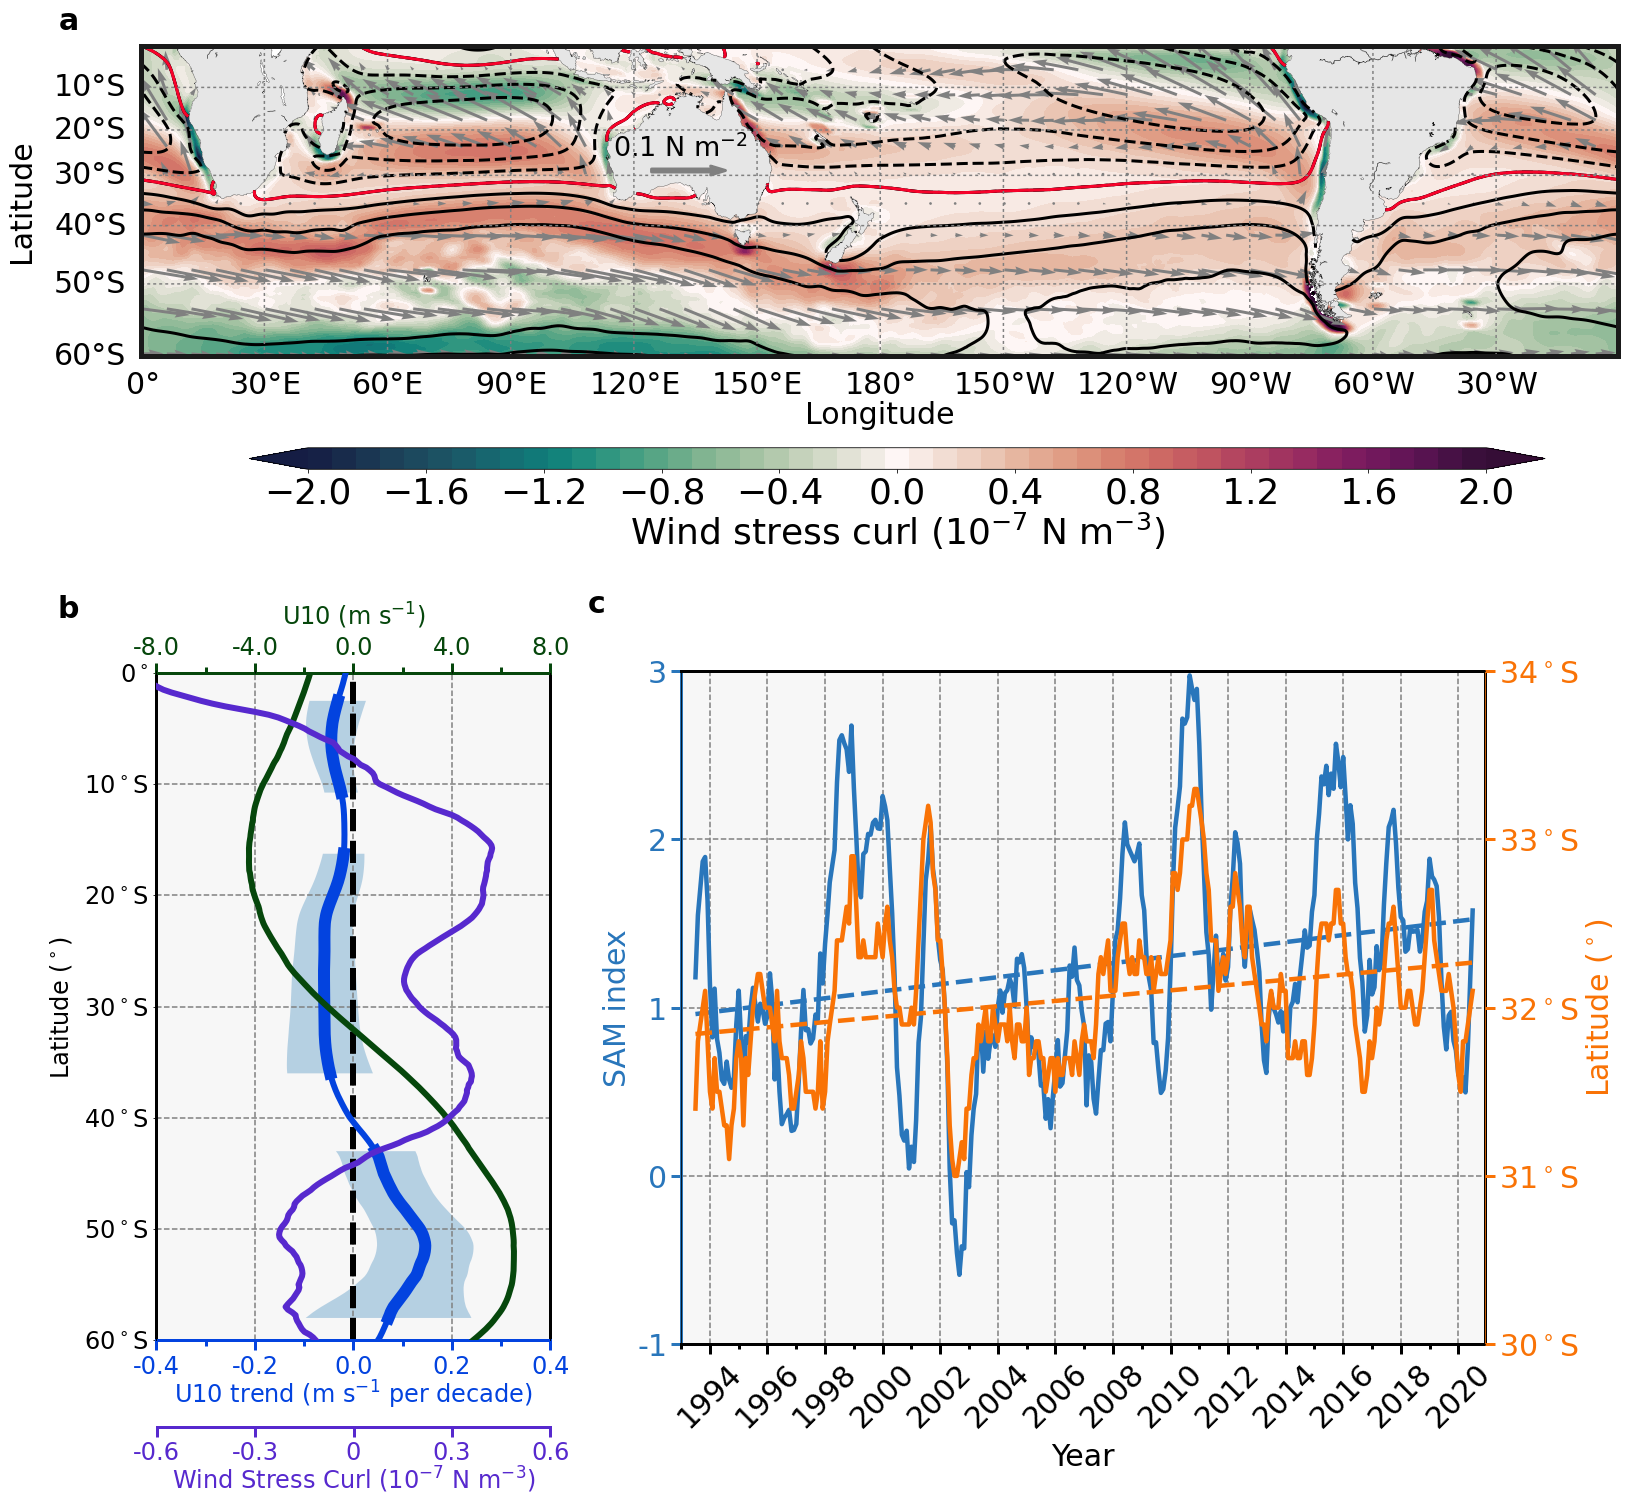

In [26]:
m   = Basemap(projection='merc',llcrnrlat=np.nanmin(lat),urcrnrlat= np.nanmax(lat),
              llcrnrlon=np.nanmin(lon),urcrnrlon=np.nanmax(lon),resolution='l')
x, y = m(lon, lat)
cx,cy  = m(-20, 4)
yy = np.arange(1, y.shape[0], 24)
xx = np.arange(1, x.shape[1], 24)
points  = np.meshgrid(yy, xx)
labels  = ['a','b','c','d','e']
levels1 = np.linspace(-2,2,50)
tick_marks1 = np.linspace(-2,2,11)
cmaps1  = cmaps.cmocean_curl
fig_ratio=0.9
fig = plt.figure(figsize=(60, 30))
gs=gridspec.GridSpec(2,3)
labelfont=30
padspacescale=15
labelpadscale=5
linefont = 3
scale  = 1.5
m_scale=10
#%%%%%%%%%%%%%%%%%%%%%%%%%%% Wind spatial distribution %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax = fig.add_subplot(gs[0])
l, b, w, h = ax.get_position().bounds
m   = Basemap(projection='merc',llcrnrlat=np.nanmin(lat),urcrnrlat= np.nanmax(lat),llcrnrlon=np.nanmin(lon),urcrnrlon=np.nanmax(lon),resolution='l')    
m.drawmeridians(np.arange(0,360, 30),labels=[0,0,0,1],linewidth=0.5*linefont,dashes=[2,2],color='.5',fontsize=labelfont)
m.drawparallels(np.arange(-60,-0, 10),labels=[1,0,0,0],linewidth=0.5*linefont,dashes=[2,2],color='.5',fontsize=labelfont)    
m.drawcoastlines(color='0.1',  linewidth=0.1*linefont)
m.drawmapboundary(color='0.1', linewidth=0.1*linefont)
m.fillcontinents(color='0.9', lake_color='white')
CB  = m.contourf(x, y, curlZ_mean,cmap=cmaps1,levels=levels1,origin='lower',extend='both')
Q   = m.quiver(x[tuple(points)],y[tuple(points)],Tx_mean[tuple(points)],Ty_mean[tuple(points)],color='gray',width=0.002,scale=2)
qk1 = plt.quiverkey(Q,0.37,0.60, 0.1, r' ',labelpos='N',color='gray',linewidth=linefont,fontproperties={'size': labelfont})
qk2 = plt.quiverkey(Q,0.365,0.602,0.1, r'0.1 N m$^{-2}$',labelpos='N',color='None',linewidth=linefont,fontproperties={'size':0.9*labelfont})
for i in range(4):
    CS1=m.contour(x, y,u10_mean,np.arange(-0.01-2*i,0.01-2*i,2),linewidths=linefont,linestyles='dashed',colors='xkcd:black')

for i in range(4):
    CS2=m.contour(x, y,u10_mean,np.arange(-0.01+2*i,0.01+2*i,2),linewidths=linefont,linestyles='solid',colors='xkcd:black')
CS=m.contour(x, y,u10_mean1,np.arange(-0.01,0.01,2),linewidths=linefont,linestyles='solid',colors='xkcd:cherry red')
m.plot(x[0,:],  y[0,:],linewidth=linefont, linestyle='solid', color='k')
m.plot(x[:,0],  y[:,0],linewidth=linefont, linestyle='solid', color='k')
m.plot(x[-1,:], y[-1,:],linewidth=linefont, linestyle='solid', color='k')
m.plot(x[:,-1], y[:,-1],linewidth=linefont, linestyle='solid', color='k')
ax.set_position([l, b, scale*w, scale*h])   
ax.spines['left'].set_linewidth(labelpadscale)
ax.spines['top'].set_linewidth(labelpadscale)
ax.spines['right'].set_linewidth(labelpadscale)
ax.spines['bottom'].set_linewidth(labelpadscale)
plt.xlabel('Longitude',fontsize=labelfont,labelpad=3.0*padspacescale,family='sans-serif')
plt.ylabel('Latitude',fontsize=labelfont,labelpad=7*padspacescale,family='sans-serif')
plt.text(cx, cy,labels[0],color='xkcd:black', fontsize=labelfont, weight='bold',family='sans-serif')
cbaxes1     = fig.add_axes([0.15, 0.67, 0.3, 0.01])
cb1 = plt.colorbar(CB,orientation='horizontal',cax = cbaxes1)
cb1.set_ticks(tick_marks1)
cb1.ax.tick_params(labelsize=1.2*labelfont)
cb1.set_label(r'Wind stress curl (10$^{-7}$ N m$^{-3}$)', fontsize=1.2*labelfont,labelpad=0)
#%%%%%%%%%%%%%%%%%%%%%%%%%% Latitude distribution of WBC and U10 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax1 = fig.add_subplot(gs[1],facecolor='0.97')
l, b, w, h = ax1.get_position().bounds
labelfont=30
padspacescale=15
labelpadscale=5
linefont = 3
scale  = 1.0
########################## U10 wind trend ############################
ax1.plot(u10_zonal_trend,  lat0, color='xkcd:blue',  linewidth=2*linefont,zorder=3)
ax1.plot(u10_zonal_trend1, lat0, color='xkcd:blue', linewidth=4*linefont)
ax1.plot([0,0], [np.min(lat0),np.max(lat0)], color='black', linewidth=2*linefont,linestyle='dashed')
ax1.fill_betweenx(lat0,u10_zonal_trend-u10_zonal_std, u10_zonal_trend+u10_zonal_std ,alpha=0.3)
ax1.set_xlabel(r'U10 trend (m s$^{-1}$ per decade)',color='xkcd:blue', fontsize=0.8*labelfont,labelpad=0)
ax1.set_ylabel(r'Latitude ($^\circ$)',fontsize=0.8*labelfont,labelpad=10)
ax1.set_xlim(-0.4, 0.4)
ax1.set_xticks(np.arange(-0.4,0.4,0.2))
ax1.set_ylim(np.min(lat0),np.max(lat0))
ax1.axes.xaxis.set_tick_params(pad=0.8*labelpadscale)
ax1.axes.yaxis.set_tick_params(colors='black',pad=0.8*labelpadscale)
xminorLocator   = plt.MultipleLocator(0.1)
xmajorLocator   = plt.MultipleLocator(0.2)
xmajorFormatter = plt.FormatStrFormatter('%3.1f')
ax1.xaxis.set_minor_locator(xminorLocator)
ax1.xaxis.set_major_locator(xmajorLocator)
ax1.xaxis.set_major_formatter(xmajorFormatter)
plt.xticks(fontsize=0.8*labelfont)
plt.yticks(np.linspace(0,-60,7),['0$^\circ$','10$^\circ$S','20$^\circ$S','30$^\circ$S','40$^\circ$S','50$^\circ$S','60$^\circ$S'],fontsize=0.8*labelfont)
plt.grid(color ="tab:gray",linestyle='dashed', linewidth=0.5*linefont)
ax1.spines['bottom'].set_linewidth(linefont)
ax1.spines['left'].set_linewidth(linefont)
ax1.spines['top'].set_linewidth(linefont)
ax1.spines['right'].set_linewidth(linefont)        
ax1.tick_params(axis='x',which='minor',bottom='on',left='on',length=6.0,width=1.0*linefont,colors='xkcd:blue',direction='out')
ax1.tick_params(axis='x',which='major',bottom='on',left='on',length=10.0,width=1.0*linefont,colors='xkcd:blue',direction='out')
ax1.spines['top'].set_color('xkcd:forest green')
ax1.spines['bottom'].set_color('xkcd:blue')
plt.text(-0.6, 5,labels[1],color='xkcd:black', fontsize=labelfont, weight='bold',family='sans-serif')
########################## U10 wind ############################
ax2 = ax1.twiny()
plt.xticks(fontsize=0.8*labelfont)
ax2.plot(mean_u10,  lat0, color='xkcd:forest green',  linewidth=2*linefont,zorder=3)
ax2.set_xlabel(r'U10 (m s$^{-1}$)',color='xkcd:forest green',fontsize=0.8*labelfont,labelpad=10)
ax2.set_xlim(-8, 8)
ax2.set_xticks(np.arange(-8,8,2))
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
xminorLocator   = plt.MultipleLocator(2)
xmajorLocator   = plt.MultipleLocator(4)
xmajorFormatter = plt.FormatStrFormatter('%3.1f')
ax2.xaxis.set_minor_locator(xminorLocator)
ax2.xaxis.set_major_locator(xmajorLocator)
ax2.xaxis.set_major_formatter(xmajorFormatter)
ax2.axes.xaxis.set_tick_params(pad=0.8*labelpadscale)
ax2.tick_params(axis='x',which='minor',top='on',length=6.0,width=1.0*linefont,colors='xkcd:forest green',direction='out')
ax2.tick_params(axis='x',which='major',top='on',length=10.0,width=1.0*linefont,colors='xkcd:forest green',direction='out')
ax2.tick_params(axis='y',which='major',top='on',length=10.0,width=1.0*linefont,colors='xkcd:black',direction='out')
########################## Wind stress curl ############################
ax3 = ax1.twiny()
ax3.plot(mean_curlZ, lat0, color='xkcd:blue purple',  linewidth=2*linefont,zorder=3)
ax3.set_xlim(-0.6e-7, 0.6e-7)
ax3.set_xticks(np.arange(-0.6e-7, 0.6e-7,0.3e-7))
ax3.axes.xaxis.set_ticklabels([]) 
ax3.spines['top'].set_color('none')
ax3.spines['bottom'].set_color('none')
ax1.set_position([l-0.27, b-0.27, 0.4*scale*w, 0.9*scale*h]) 
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax4 = fig.add_subplot(gs[2],facecolor='none')
l, b, w, h = ax4.get_position().bounds
ax4.set_xlabel(r'Wind Stress Curl (10$^{-7}$ N m$^{-3}$)',color='xkcd:blue purple',fontsize=0.8*labelfont,labelpad=0)
ax4.set_xlim(-0.6e-7, 0.6e-7)
ax4.set_ylim(np.min(lat0),np.max(lat0))
plt.xticks(np.linspace(-0.6e-7,0.6e-7,5), ['-0.6', '-0.3','0', '0.3','0.6'],fontsize=0.8*labelfont)
plt.xticks(fontsize=0.8*labelfont)
plt.yticks(fontsize=0*labelfont)
ax4.axes.xaxis.set_tick_params(pad=0.8*labelpadscale)
ax4.tick_params(axis='x',which='minor',bottom='on',length=5.0,width=1.0*linefont,colors='xkcd:blue purple',direction='out')
ax4.tick_params(axis='x',which='major',bottom='on',length=10.0,width=1.0*linefont,colors='xkcd:blue purple',direction='out')
ax4.tick_params(axis='y',which='major',right='off',length=10.0,width=0*linefont,colors='none',direction='out')
ax4.axes.yaxis.set_ticklabels([])  
ax4.spines['bottom'].set_linewidth(linefont)
ax4.spines['bottom'].set_color('xkcd:blue purple')
ax4.spines['top'].set_color('none')
ax4.spines['left'].set_color('none')
ax4.spines['right'].set_color('none')
ax4.set_position([l-0.5435, b-0.31, 0.4*scale*w, 0.9*scale*h]) 
#%%%%%%%%%%%%%%%%%%%%%%%%%% Time series of SAM index %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax5 = fig.add_subplot(gs[3],facecolor='0.97')
l, b, w, h = ax5.get_position().bounds
labelfont  = 30
padspacescale=15
labelpadscale=5
linefont = 3
scale  = 1.02
ax5.plot(t_range, SAM_index, color='xkcd:bluish', linewidth=1.5*linefont)
ax5.plot(t_range, SAM_index_trend, color='xkcd:bluish', linewidth=1.5*linefont,linestyle='dashed')
ax5.set_ylabel(r'SAM index',fontsize=1.0*labelfont,labelpad=5,color='xkcd:bluish')
ax5.set_ylim(-1,3)
ax5.axes.xaxis.set_tick_params(pad=0.8*labelpadscale)
ax5.axes.yaxis.set_tick_params(colors='black',pad=0.8*labelpadscale)
plt.xlim(t_range[0]-6,t_range[-1]+5)
xminorLocator   = mpl.dates.YearLocator(1)
xmajorLocator   = mpl.dates.YearLocator(2)
xmajorFormatter = mpl.dates.DateFormatter('%Y')
ax5.set_yticks(np.linspace(-1,3.15,5))
ax5.set_yticklabels(['-1','0','1','2','3'])
ax5.xaxis.set_minor_locator(xminorLocator)
ax5.xaxis.set_major_locator(xmajorLocator)
ax5.xaxis.set_major_formatter(xmajorFormatter)
ax5.axes.yaxis.set_tick_params(colors='black',pad=0.8*labelpadscale)
plt.yticks(fontsize=1.0*labelfont)
plt.xticks(fontsize=1.0*labelfont,rotation=45)
plt.grid(color ="tab:gray",linestyle='dashed', linewidth=0.5*linefont)
ax5.yaxis.set_label_position("left")
ax5.spines['bottom'].set_linewidth(linefont)
ax5.spines['left'].set_linewidth(linefont)
ax5.spines['top'].set_linewidth(linefont)
ax5.spines['right'].set_linewidth(linefont)        
ax5.tick_params(axis='x',which='minor',bottom='on',length=5.0,width=1.0*linefont,colors='xkcd:black',direction='out')
ax5.tick_params(axis='x',which='major',bottom='on',length=10.0,width=1.0*linefont,colors='xkcd:black',direction='out')
ax5.tick_params(axis='y',which='major',left='on',length=10.0,width=1.0*linefont,colors='xkcd:bluish',direction='out')
ax5.spines['top'].set_color('xkcd:black')
ax5.spines['left'].set_color('xkcd:bluish')
ax5.set_xlabel('Year',fontsize=labelfont,labelpad=10,family='sans-serif')
########################## latitudes of zero wind stress line ############################
ax6 = ax5.twinx()
ax6.plot(t_range, latitudes_0_u10, color='xkcd:orange', linewidth=1.5*linefont)
ax6.plot(t_range, latitudes_0_u10_trend, color='xkcd:orange', linewidth=1.5*linefont,linestyle='dashed')
ax6.set_ylabel(r'Latitude ($^\circ$)',fontsize=1.0*labelfont,labelpad=5,color='xkcd:orange')
ax6.set_ylim(-34,-30)
ax6.invert_yaxis()
ax6.axes.xaxis.set_tick_params(pad=0.8*labelpadscale)
ax6.yaxis.set_label_position("right")
ax6.axes.yaxis.set_tick_params(colors='black',pad=0.8*labelpadscale)
plt.xlim(t_range[0]-6,t_range[-1]+5)
xminorLocator   = mpl.dates.YearLocator(1)
xmajorLocator   = mpl.dates.YearLocator(2)
xmajorFormatter = mpl.dates.DateFormatter('%Y')
ax6.axes.xaxis.set_ticklabels([]) 
ax6.xaxis.set_minor_locator(xminorLocator)
ax6.xaxis.set_major_locator(xmajorLocator)
ax6.xaxis.set_major_formatter(xmajorFormatter)
ax6.set_yticks(np.linspace(-30,-34,5))
ax6.set_yticklabels(['30$^\circ$S','31$^\circ$S','32$^\circ$S','33$^\circ$S','34$^\circ$S'])
ax6.axes.yaxis.set_tick_params(colors='black',pad=0.8*labelpadscale)
plt.yticks(fontsize=1.0*labelfont)   
ax6.tick_params(axis='y',which='major',right='on',length=10.0,width=1.0*linefont,colors='xkcd:orange',direction='out')
ax6.spines['right'].set_color('xkcd:orange')
plt.text(t_range[0]-45, -34.35,labels[2],color='xkcd:black', fontsize=labelfont, weight='bold',family='sans-serif')
ax5.set_position([l+0.125, b+0.14, 0.8*scale*w, 0.89*scale*h]) 
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
fig.savefig(directory+'/BRAN_WBC/SO/Figure5_wind_SAM.pdf',dpi=300,bbox_inches = 'tight')